In [ ]:
'''# Install the plot package
!pip install plotly'''

In [22]:
# Import the packages
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from sklearn.svm import SVR
from scipy.stats import pearsonr
from scipy.stats import linregress
import scipy.stats

In [23]:
# Connect with the MongoDB Server
client = pymongo.MongoClient('localhost', 27017)
db = client['comp6235']
all_weather = db['all_weather']
london_historical_weather = db['london_historical_weather']
uk_energy = db['uk_energy']

In [24]:
query = [
    {'$match':{'city_name':{'$eq':'London'}}}
]

q = all_weather.aggregate(query)
df = pd.DataFrame(list(q))
df

,_id,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,6572a97e5bffd97e20d20844,3772,London,2013-01-02,Winter,6.9,2.0,10.9,0.0,0.0,239.0,14.6,0.0,0.0,0.0
1,6572a97e5bffd97e20d20845,3772,London,2013-01-03,Winter,10.6,8.5,11.3,0.3,0.0,256.0,18.6,0.0,0.0,0.0
2,6572a97e5bffd97e20d20846,3772,London,2013-01-04,Winter,9.6,8.2,10.4,0.0,0.0,262.0,17.4,0.0,1037.4,0.0
3,6572a97e5bffd97e20d20847,3772,London,2013-01-05,Winter,9.2,8.0,10.8,0.0,0.0,240.0,14.1,0.0,1035.3,0.0
4,6572a97e5bffd97e20d20848,3772,London,2013-01-06,Winter,7.3,6.0,8.9,0.3,0.0,211.0,9.9,0.0,1032.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,6572a97e5bffd97e20d21681,3772,London,2022-12-26,Winter,6.8,3.4,10.4,1.5,0.0,240.0,19.7,54.0,1015.6,0.0
3646,6572a97e5bffd97e20d21682,3772,London,2022-12-27,Winter,6.9,1.9,10.8,0.0,0.0,205.0,18.7,57.0,1019.3,0.0
3647,6572a97e5bffd97e20d21683,3772,London,2022-12-28,Winter,10.7,8.2,12.0,5.8,0.0,203.0,26.7,57.0,1001.9,0.0
3648,6572a97e5bffd97e20d21684,3772,London,2022-12-29,Winter,8.5,6.0,11.7,4.1,0.0,222.0,26.8,58.0,1000.9,0.0


In [5]:
temperature = df['avg_temp_c']
rainfall = df['precipitation_mm']
wind_speed = df['avg_wind_speed_kmh']

In [9]:
df = pd.DataFrame({'Temperature': temperature, 'Rainfall': rainfall, 'Wind Speed': wind_speed})

# Calculate the relativity using Spearman Method
correlation_matrix = df.corr(method='spearman')

styled_correlation_matrix = correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(4)

styled_correlation_matrix

C:\Users\77431\AppData\Local\Temp\ipykernel_91844\418456934.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  styled_correlation_matrix = correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(4)


,Temperature,Rainfall,Wind Speed
Temperature,1.0000,-0.1511,-0.0173
Rainfall,-0.1511,1.0000,0.2294
Wind Speed,-0.0173,0.2294,1.0000


## Relativity under Extreme Weather

In [10]:
# Threshold
percentile1=95
percentile2=5
query_hot = [
    {'$match':{'city_name':{'$eq':'London'}}},
    {'$match':{'season':{'$eq':'Summer'}}},
    {
        "$group": {
            "_id": None,
            "avg_temp_c": {"$push": "$avg_temp_c"}
        }
    },
    {
        "$project": {
            "avg_temp_c": 1,
            "p95_hot_value": {
                "$arrayElemAt": [
                    "$avg_temp_c",
                    {
                        "$floor": {
                            "$multiply": [percentile1 / 100, {"$size": "$avg_temp_c"}]
                        }
                    }
                ]
            }
        }
    }
]

result_hot = all_weather.aggregate(query_hot)
hot_value = list(result_hot)[0]['p95_hot_value']

query_cold = [
    {'$match':{'city_name':{'$eq':'London'}}},
    {'$match':{'season':{'$eq':'Winter'}}},
    {
        "$group": {
            "_id": None,
            "avg_temp_c": {"$push": "$avg_temp_c"}
        }
    },
    {
        "$project": {
            "avg_temp_c": 1,
            "p5_cold": {
                "$arrayElemAt": [
                    "$avg_temp_c",
                    {
                        "$floor": {
                            "$multiply": [percentile2 / 100, {"$size": "$avg_temp_c"}]
                        }
                    }
                ]
            }
        }
    }
]

result_cold = all_weather.aggregate(query_cold)
cold_value = list(result_cold)[0]['p5_cold']

query_hot_select = [
    {'$match':{'city_name':{'$eq':'London'}}},
    {'$match':{'max_temp_c':{'$gt':hot_value}}},
]
result_hot_select = all_weather.aggregate(query_hot_select)
df_hot = pd.DataFrame(list(result_hot_select))


query_cold_select = [
    {'$match':{'city_name':{'$eq':'London'}}},
    {'$match':{'avg_temp_c':{'$lt':cold_value}}},
]
result_cold_select = all_weather.aggregate(query_cold_select)
df_cold = pd.DataFrame(list(result_cold_select))

In [11]:
temperature_hot = df_hot['avg_temp_c']
rainfall_hot = df_hot['precipitation_mm']
wind_speed_hot = df_hot['avg_wind_speed_kmh']

temperature_cold = df_cold['avg_temp_c']
rainfall_cold = df_cold['precipitation_mm']
wind_speed_cold = df_cold['avg_wind_speed_kmh']

## Relativity on Weather Features

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Temperature'),
  Text(0, 1.5, 'Rainfall'),
  Text(0, 2.5, 'Wind Speed')])

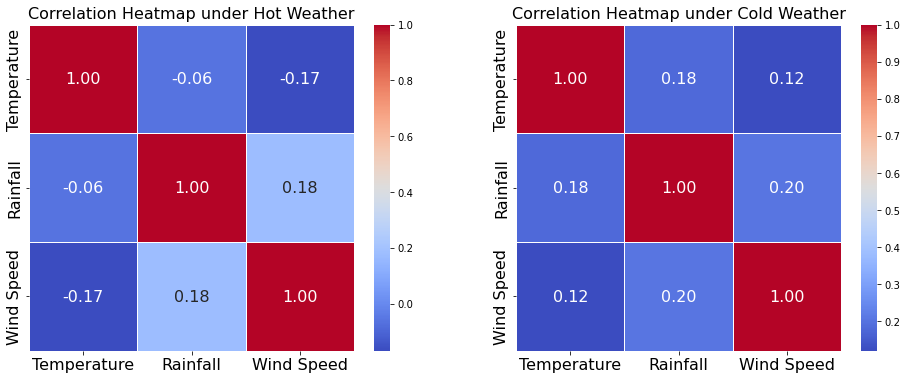

In [14]:
df_hot_select = pd.DataFrame({'Temperature': temperature_hot, 'Rainfall': rainfall_hot, 'Wind Speed': wind_speed_hot})
df_cold_select = pd.DataFrame({'Temperature': temperature_cold, 'Rainfall': rainfall_cold, 'Wind Speed': wind_speed_cold})

# Correlation
correlation_matrix_hot = df_hot_select.corr(method='spearman')
correlation_matrix_cold = df_cold_select.corr(method='spearman')

# Visualize with HeatMap
plt.figure(figsize=(16, 6))

plt.subplot(121)
sns.heatmap(correlation_matrix_hot, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.7, annot_kws={"size": 16})
plt.title('Correlation Heatmap under Hot Weather', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(122)
sns.heatmap(correlation_matrix_cold, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.7, annot_kws={"size": 16})
plt.title('Correlation Heatmap under Cold Weather', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Scatter Chart about the Temperature and Wind Speed

Slope (斜率): -0.3109361175156044
Intercept (截距): 18.94732967270674
Slope (斜率): 0.3282674457416834
Intercept (截距): 11.225436152024148


C:\Users\77431\AppData\Local\Temp\ipykernel_36612\3882705989.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()
C:\Users\77431\AppData\Local\Temp\ipykernel_36612\3882705989.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


Text(0, 0.5, 'Wind Speed (m/s)')

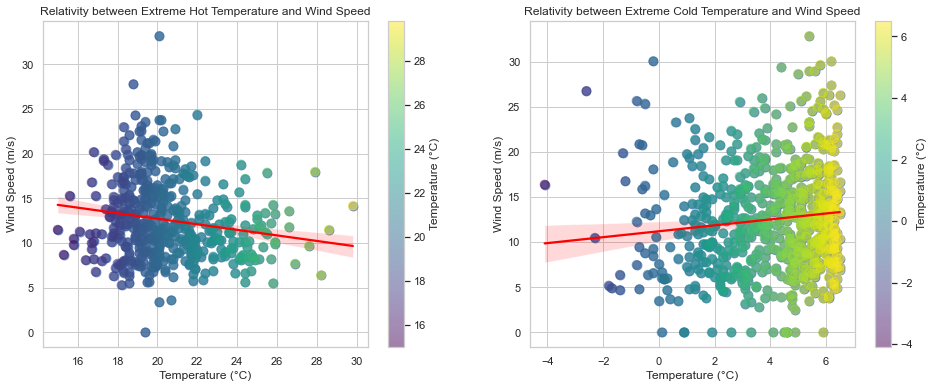

In [33]:
t_w_hot = pd.DataFrame({'Temperature': temperature_hot, 'Wind Speed': wind_speed_hot})
t_w_cold = pd.DataFrame({'Temperature': temperature_cold, 'Wind Speed': wind_speed_cold})

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))

plt.subplot(121)

'''Extreme Hot'''
sns.regplot(x='Temperature', y='Wind Speed', data=t_w_hot, scatter_kws={'s': 80, 'alpha': 0.7}, line_kws={'color': 'red'})
plt.scatter(temperature_hot, wind_speed_hot, c=temperature_hot, cmap='viridis', s=80, alpha=0.5)

cbar = plt.colorbar()
cbar.set_label('Temperature (°C)')

slope, intercept = np.polyfit(temperature_hot, wind_speed_hot, 1)

print(f"Slope : {slope}")
print(f"Intercept : {intercept}")

plt.title('Relativity between Extreme Hot Temperature and Wind Speed')
plt.xlabel('Temperature (°C)')
plt.ylabel('Wind Speed (m/s)')

'''Extreme Cold'''
plt.subplot(122)
sns.regplot(x='Temperature', y='Wind Speed', data=t_w_cold, scatter_kws={'s': 80, 'alpha': 0.7}, line_kws={'color': 'red'})
plt.scatter(temperature_cold, wind_speed_cold, c=temperature_cold, cmap='viridis', s=80, alpha=0.5)

cbar = plt.colorbar()
cbar.set_label('Temperature (°C)')

slope, intercept = np.polyfit(temperature_cold, wind_speed_cold, 1)

print(f"Slope : {slope}")
print(f"Intercept : {intercept}")

plt.title('Relativity between Extreme Cold Temperature and Wind Speed')
plt.xlabel('Temperature (°C)')
plt.ylabel('Wind Speed (m/s)')

### Extreme Temperature and Rainfall

Slope (斜率): -0.0564571395563366
Intercept (截距): 1.761060077681155
Slope (斜率): 0.19774896415957283
Intercept (截距): 0.6623281992212419


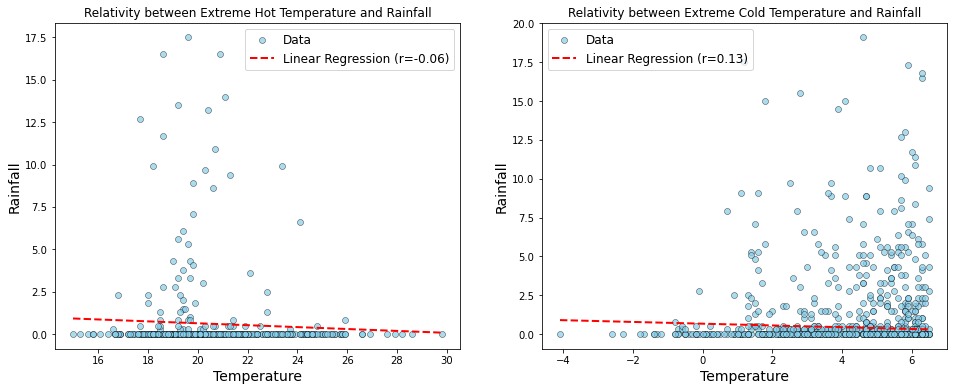

In [32]:
slope_hot, intercept_hot, r_value_hot, p_value_hot, std_err_hot = linregress(temperature_hot, rainfall_hot)
slope_cold, intercept_cold, r_value_cold, p_value_cold, std_err_cold = linregress(temperature_cold, rainfall_cold)

print(f"Slope : {slope_hot}")
print(f"Intercept : {intercept_hot}")
print(f"Slope : {slope_cold}")
print(f"Intercept : {intercept_cold}")

plt.figure(figsize=(16, 6))

'''Extreme Hot Weather'''
plt.subplot(121)

plt.scatter(temperature_hot, rainfall_hot, c='skyblue', alpha=0.7, edgecolor='black', linewidth=0.5, label='Data')

line_x_hot = np.linspace(min(temperature_hot), max(temperature_hot), 100)
line_y_hot = slope_hot * line_x_hot + intercept_hot
plt.plot(line_x_hot, line_y_hot, color='red', linestyle='--', linewidth=2, label=f'Linear Regression (r={r_value_hot:.2f})')

plt.title('Relativity between Extreme Hot Temperature and Rainfall', fontsize=12)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Rainfall', fontsize=14)
plt.legend(fontsize=12)

'''Extreme Cold Weather'''
plt.subplot(122)

plt.scatter(temperature_cold, rainfall_cold, c='skyblue', alpha=0.7, edgecolor='black', linewidth=0.5, label='Data')

line_x_cold = np.linspace(min(temperature_cold), max(temperature_cold), 100)
line_y_cold = slope_hot * line_x_cold + intercept_cold
plt.plot(line_x_cold, line_y_cold, color='red', linestyle='--', linewidth=2, label=f'Linear Regression (r={r_value_cold:.2f})')

plt.title('Relativity between Extreme Cold Temperature and Rainfall', fontsize=12)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Rainfall', fontsize=14)
plt.legend(fontsize=12)

### Scatter Chart (Wind Speed & Rainfall)

Text(0, 0.5, 'Rainfall')

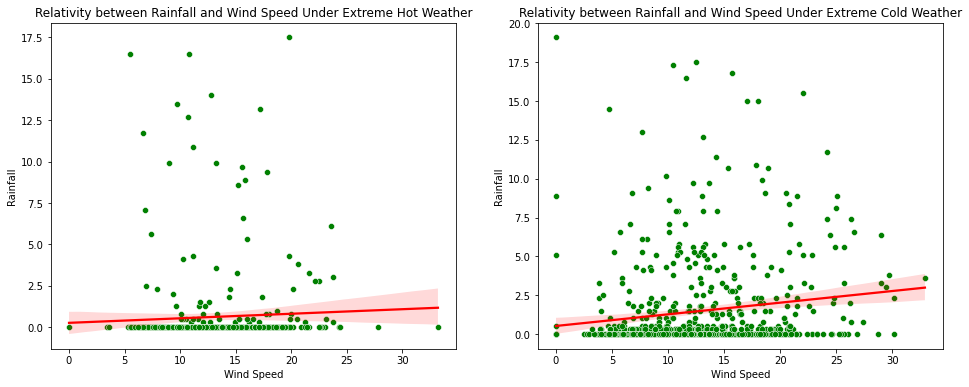

In [23]:
plt.figure(figsize=(16, 6))

'''Extreme Hot'''
plt.subplot(121)
df_hot_rain_wind = pd.DataFrame({'Rainfall': rainfall_hot, 'Wind Speed': wind_speed_hot})
sns.scatterplot(x='Wind Speed', y='Rainfall', data=df_hot_rain_wind, color='green')
sns.regplot(x='Wind Speed', y='Rainfall', data=df_hot_rain_wind, scatter=False, color='red')

plt.title('Relativity between Rainfall and Wind Speed Under Extreme Hot Weather', fontsize=12)
plt.xlabel('Wind Speed')
plt.ylabel('Rainfall')

'''Extreme Cold'''
plt.subplot(122)
df_cold_rain_wind = pd.DataFrame({'Rainfall': rainfall_cold, 'Wind Speed': wind_speed_cold})
sns.scatterplot(x='Wind Speed', y='Rainfall', data=df_cold_rain_wind, color='green')
sns.regplot(x='Wind Speed', y='Rainfall', data=df_cold_rain_wind, scatter=False, color='red')

plt.title('Relativity between Rainfall and Wind Speed Under Extreme Cold Weather', fontsize=12)
plt.xlabel('Wind Speed')
plt.ylabel('Rainfall')

## Influence on Energy Consumption

In [16]:
q = uk_energy.find({})
e = pd.DataFrame(list(q))
e

,_id,Year,Energy from renewable & waste sources,Total energy consumption of primary fuels and equivalents,Fraction from renewable sources and waste,Hydroelectric power,"Wind, wave, tidal",Solar photovoltaic,Geothermal aquifers,Landfill gas,...,Municipal solid waste (MSW),Poultry litter,Straw,Wood,Charcoal,Liquid bio-fuels,Bioethanol,Biodiesel,Biomass,Cross-boundary Adjustment
0,6572ae495bffd97e20d82d89,1990,1.647,225.532,0.007,0.448,0.001,0.000,0.001,0.080,...,0.183,0.000,0.007,0.687,0.039,0.000,0.000,0.000,0.065,0.000
1,6572ae495bffd97e20d82d8a,1991,1.634,231.288,0.007,0.398,0.001,0.000,0.001,0.105,...,0.185,0.000,0.007,0.687,0.036,0.000,0.000,0.000,0.065,0.000
2,6572ae495bffd97e20d82d8b,1992,1.843,228.696,0.008,0.467,0.003,0.000,0.001,0.155,...,0.210,0.016,0.007,0.736,0.033,0.000,0.000,0.000,0.065,0.000
3,6572ae495bffd97e20d82d8c,1993,1.862,231.368,0.008,0.370,0.019,0.000,0.001,0.162,...,0.268,0.043,0.007,0.736,0.034,0.000,0.000,0.000,0.065,0.000
4,6572ae495bffd97e20d82d8d,1994,2.528,230.739,0.011,0.438,0.030,0.000,0.001,0.188,...,0.385,0.101,0.007,1.108,0.034,0.000,0.000,0.000,0.065,0.000
5,6572ae495bffd97e20d82d8e,1995,2.644,230.886,0.011,0.416,0.034,0.000,0.001,0.199,...,0.411,0.101,0.007,1.182,0.035,0.000,0.000,0.000,0.065,0.000
6,6572ae495bffd97e20d82d8f,1996,2.581,243.392,0.011,0.292,0.042,0.000,0.001,0.249,...,0.396,0.101,0.007,1.194,0.041,0.000,0.000,0.000,0.065,0.000
7,6572ae495bffd97e20d82d90,1997,2.611,240.756,0.011,0.378,0.057,0.000,0.001,0.317,...,0.465,0.101,0.007,0.991,0.038,0.000,0.000,0.000,0.065,0.000
8,6572ae495bffd97e20d82d91,1998,3.013,246.790,0.012,0.440,0.075,0.000,0.001,0.402,...,0.649,0.112,0.007,1.077,0.040,0.000,0.000,0.000,0.029,0.000
9,6572ae495bffd97e20d82d92,1999,3.148,246.112,0.013,0.459,0.073,0.000,0.001,0.572,...,0.633,0.148,0.007,0.959,0.033,0.000,0.000,0.000,0.074,0.000


In [17]:
# Select historical temperature data from London_historical_Weather Dataset
query_past_t = [
    {
        "$set": {
            "date": {
                "$toDate": {
                    "$dateToString": {
                        "date": {"$dateFromParts": {"year": {"$floor": {"$divide": ["$date", 10000]}},"month": {"$floor": {"$mod": [{"$divide": ["$date", 100]}, 100]}},"day": {"$mod": ["$date", 100]}}},
                        "format": "%Y-%m-%d"
                    }
                }
            }
        }
    },
    {"$match": {"date": {"$gte": datetime(1990, 1, 1)}}},
    {'$group':{'_id':{'$year':{'$toDate':'$date'}}, 'avg_temp':{'$avg':'$mean_temp'}, 'avg_sunshine':{'$avg':'$sunshine'}, 'avg_pressure':{'$avg':'$pressure'}}},
    {'$sort':{'_id':1}}
]

result_past_t = london_historical_weather.aggregate(query_past_t)
df_past_t = pd.DataFrame(list(result_past_t))
df_past_t

,_id,avg_temp,avg_sunshine,avg_pressure
0,1990,12.083562,5.225205,101611.178082
1,1991,10.711507,4.115342,101731.369863
2,1992,11.228142,3.939891,101663.278689
3,1993,10.854795,4.066027,101645.917808
4,1994,11.720548,4.581644,101453.808219
5,1995,11.926849,5.156712,101566.000000
6,1996,10.550820,4.685792,101541.748634
7,1997,12.043836,4.944110,101638.986301
8,1998,11.661918,4.325479,101499.369863
9,1999,11.953425,4.968767,101404.493151


In [18]:
# Combine two DataFrame into one Energy DataFrame
e['avg_temperature'] = round(df_past_t['avg_temp'], 4)
e['sunshine'] = round(df_past_t['avg_sunshine'], 4)
e['pressure'] = round(df_past_t['avg_pressure'], 4)
data_energy = e.drop('_id', axis=1)
data_energy

,Year,Energy from renewable & waste sources,Total energy consumption of primary fuels and equivalents,Fraction from renewable sources and waste,Hydroelectric power,"Wind, wave, tidal",Solar photovoltaic,Geothermal aquifers,Landfill gas,Sewage gas,...,Wood,Charcoal,Liquid bio-fuels,Bioethanol,Biodiesel,Biomass,Cross-boundary Adjustment,avg_temperature,sunshine,pressure
0,1990,1.647,225.532,0.007,0.448,0.001,0.000,0.001,0.080,0.138,...,0.687,0.039,0.000,0.000,0.000,0.065,0.000,12.0836,5.2252,101611.1781
1,1991,1.634,231.288,0.007,0.398,0.001,0.000,0.001,0.105,0.151,...,0.687,0.036,0.000,0.000,0.000,0.065,0.000,10.7115,4.1153,101731.3699
2,1992,1.843,228.696,0.008,0.467,0.003,0.000,0.001,0.155,0.151,...,0.736,0.033,0.000,0.000,0.000,0.065,0.000,11.2281,3.9399,101663.2787
3,1993,1.862,231.368,0.008,0.370,0.019,0.000,0.001,0.162,0.158,...,0.736,0.034,0.000,0.000,0.000,0.065,0.000,10.8548,4.0660,101645.9178
4,1994,2.528,230.739,0.011,0.438,0.030,0.000,0.001,0.188,0.170,...,1.108,0.034,0.000,0.000,0.000,0.065,0.000,11.7205,4.5816,101453.8082
5,1995,2.644,230.886,0.011,0.416,0.034,0.000,0.001,0.199,0.193,...,1.182,0.035,0.000,0.000,0.000,0.065,0.000,11.9268,5.1567,101566.0000
6,1996,2.581,243.392,0.011,0.292,0.042,0.000,0.001,0.249,0.193,...,1.194,0.041,0.000,0.000,0.000,0.065,0.000,10.5508,4.6858,101541.7486
7,1997,2.611,240.756,0.011,0.378,0.057,0.000,0.001,0.317,0.192,...,0.991,0.038,0.000,0.000,0.000,0.065,0.000,12.0438,4.9441,101638.9863
8,1998,3.013,246.790,0.012,0.440,0.075,0.000,0.001,0.402,0.181,...,1.077,0.040,0.000,0.000,0.000,0.029,0.000,11.6619,4.3255,101499.3699
9,1999,3.148,246.112,0.013,0.459,0.073,0.000,0.001,0.572,0.189,...,0.959,0.033,0.000,0.000,0.000,0.074,0.000,11.9534,4.9688,101404.4932


Text(0.5, 1.0, 'Energy Consumption Trends Over Years')

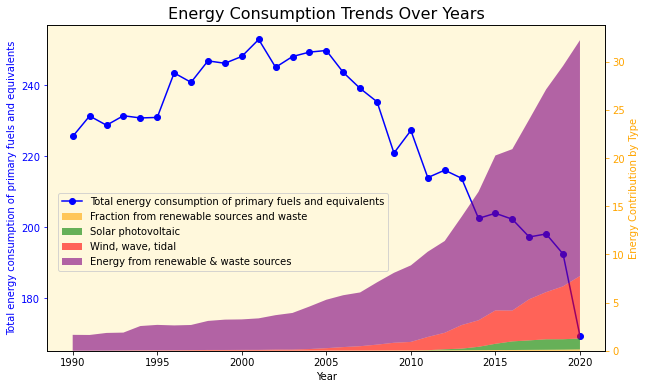

In [19]:
plt.rcParams['axes.facecolor'] = '#FFF8DC'
labels = ['Fraction from renewable sources and waste', 'Solar photovoltaic', 'Wind, wave, tidal', 'Energy from renewable & waste sources']

colors = ['orange', 'green', 'red', 'purple']

fig, ax1 = plt.subplots(figsize=(10, 6))

# Total Energy Consumption
ax1.plot(data_energy['Year'], data_energy['Total energy consumption of primary fuels and equivalents'], color='blue', marker='o', label='Total energy consumption of primary fuels and equivalents')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total energy consumption of primary fuels and equivalents', color='blue')
ax1.tick_params('y', colors='blue')

# Contribution by Different Energy Types
ax2 = ax1.twinx()
ax2.stackplot(data_energy['Year'], data_energy[labels].values.T, labels=labels, colors=colors, alpha=0.6)
ax2.set_ylabel('Energy Contribution by Type', color=colors[0])
ax2.tick_params('y', colors=colors[0])

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor=(0.62, 0.5))

plt.title('Energy Consumption Trends Over Years', fontsize=16)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'sunshine'),
  Text(0, 1.5, 'Solar photovoltaic'),
  Text(0, 2.5, 'pressure'),
  Text(0, 3.5, 'Wind, wave, tidal')])

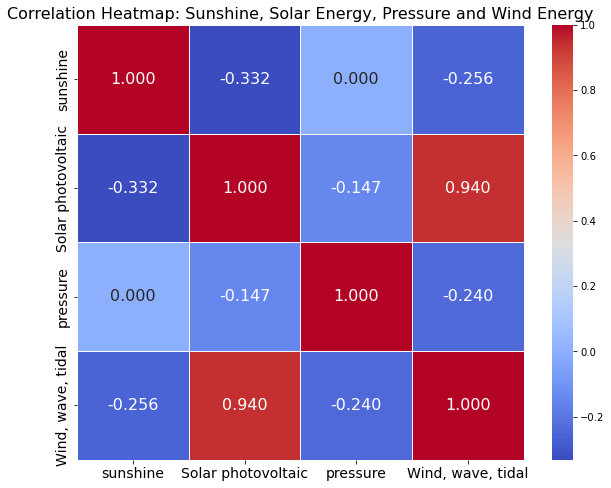

In [21]:
# Relativity (Pressure changes & Wind Energy)(Sunshine changes & Sloar Photovoltaic)

# Select data
data_to_plot = data_energy[['sunshine', 'Solar photovoltaic', 'pressure', 'Wind, wave, tidal']]

correlation_matrix = data_to_plot.corr(method='spearman')

# Heat Map
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, annot_kws={"size": 16})
plt.title('Correlation Heatmap: Sunshine, Solar Energy, Pressure and Wind Energy', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

